In [1]:
#Importing libraries
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from gensim.models import Word2Vec
from absl import logging
from yellowbrick.text import TSNEVisualizer
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy import spatial
from sklearn.manifold import TSNE

import tensorflow_hub as hub
import tensorflow as tf
import xgboost as xgb
import pandas as pd
import numpy as np
import warnings
import urllib.request
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%matplotlib inline

/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
#Loading movie reviews data
data = load_files('datasets/txt_sentoken')

In [4]:
print(data.data[0][:500])

b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so cal"


In [5]:
#Understand data
print(data.keys())
print(len(data.data))
print(data.target_names)
print(data.target)

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])
2000
['neg', 'pos']
[0 1 1 ... 1 0 0]


In [6]:
#Initializing result matrix
result_df = pd.DataFrame(index = ["BoW","TF-IDF","Word2Vec(CBoW)","Word2Vec(Skip-Gram)","ELMo","USE"], columns = ["Logistic Regression","Naive Bayes","K-Nearest Neighbours","Support Vector Machine","Random Forest"])
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,NaN,NaN,NaN,NaN,NaN
TF-IDF,NaN,NaN,NaN,NaN,NaN
Word2Vec(CBoW),NaN,NaN,NaN,NaN,NaN
Word2Vec(Skip-Gram),NaN,NaN,NaN,NaN,NaN
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,NaN,NaN,NaN,NaN


## CountVectorizer (Bag-of-Words)

### Basic Syntax

In [7]:
#Fitting CountVectorizer with 10 features
count_vect = CountVectorizer(max_features=10, stop_words='english')
X = count_vect.fit_transform(data.data).toarray()  # Returns a sparse matric which we convert to an array

#Put together a df with the results
bow_df = pd.DataFrame(X, columns=count_vect.get_feature_names_out(), index=range(0,len(data.data)))
bow_df['target'] = data.target 
bow_df.head()

,character,characters,film,good,just,like,movie,story,time,way,target
0,1,0,8,0,3,6,4,0,0,0,0
1,4,1,8,1,0,0,3,4,0,0,1
2,0,0,0,0,0,0,5,0,1,0,1
3,2,2,1,1,0,2,1,2,0,0,0
4,0,1,1,0,0,0,0,0,2,0,1


### Naive Bayes

In [8]:
params = {"count_vectorizer__max_features": [5,10,20],
          "naivebayes__alpha": [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}

clf = Pipeline([("count_vectorizer", CountVectorizer(stop_words='english')),
                ("naivebayes", MultinomialNB())])

In [9]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(data.data, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Pipeline(steps=[('count_vectorizer',
                 CountVectorizer(max_features=20, stop_words='english')),
                ('naivebayes', MultinomialNB(alpha=0.1))])
0.6369999999999999


In [10]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(data.data, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Pipeline(steps=[('count_vectorizer',
                 CountVectorizer(max_features=20, stop_words='english')),
                ('naivebayes', MultinomialNB(alpha=0.01))])
0.6369999999999999


In [11]:
#Save best score
result_df.loc["BoW","Naive Bayes"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,NaN,0.637,NaN,NaN,NaN
TF-IDF,NaN,NaN,NaN,NaN,NaN
Word2Vec(CBoW),NaN,NaN,NaN,NaN,NaN
Word2Vec(Skip-Gram),NaN,NaN,NaN,NaN,NaN
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,NaN,NaN,NaN,NaN


### Logistic Regression

In [12]:
params = {"count_vectorizer__max_features": [5,10,20],
          "logreg__C": np.logspace(-3,3,7),
          "logreg__penalty":["l1","l2"]}

clf = Pipeline([("count_vectorizer", CountVectorizer(stop_words='english')),
                ("logreg", LogisticRegression())])

In [13]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(data.data, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Pipeline(steps=[('count_vectorizer',
                 CountVectorizer(max_features=20, stop_words='english')),
                ('logreg', LogisticRegression(C=0.01))])
0.658


In [14]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(data.data, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Pipeline(steps=[('count_vectorizer',
                 CountVectorizer(max_features=20, stop_words='english')),
                ('logreg', LogisticRegression(C=0.01))])
0.658


In [15]:
#Save best score
result_df.loc["BoW","Logistic Regression"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,NaN,NaN,NaN
TF-IDF,NaN,NaN,NaN,NaN,NaN
Word2Vec(CBoW),NaN,NaN,NaN,NaN,NaN
Word2Vec(Skip-Gram),NaN,NaN,NaN,NaN,NaN
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,NaN,NaN,NaN,NaN


### K-Nearest Neighbours

In [16]:
params = {"count_vectorizer__max_features": [5,10,20],
          "knn__n_neighbors": [1,5,10,20]}

clf = Pipeline([("count_vectorizer", CountVectorizer(stop_words='english')),
                ("knn", KNeighborsClassifier())])

In [17]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(data.data, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Pipeline(steps=[('count_vectorizer',
                 CountVectorizer(max_features=20, stop_words='english')),
                ('knn', KNeighborsClassifier(n_neighbors=10))])
0.5725


In [18]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(data.data, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Pipeline(steps=[('count_vectorizer',
                 CountVectorizer(max_features=20, stop_words='english')),
                ('knn', KNeighborsClassifier(n_neighbors=10))])
0.5725


In [19]:
#Save best score
result_df.loc["BoW","K-Nearest Neighbours"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,NaN,NaN
TF-IDF,NaN,NaN,NaN,NaN,NaN
Word2Vec(CBoW),NaN,NaN,NaN,NaN,NaN
Word2Vec(Skip-Gram),NaN,NaN,NaN,NaN,NaN
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,NaN,NaN,NaN,NaN


### SVM

In [20]:
params = {"count_vectorizer__max_features": [5,10,20],
          "svc__C": [.01, .1, 1, 10, 100]}

clf = Pipeline([("count_vectorizer", CountVectorizer(stop_words='english')),
                ("svc", LinearSVC())])

In [21]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(data.data, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Pipeline(steps=[('count_vectorizer',
                 CountVectorizer(max_features=20, stop_words='english')),
                ('svc', LinearSVC(C=0.1))])
0.654


In [22]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(data.data, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Pipeline(steps=[('count_vectorizer',
                 CountVectorizer(max_features=20, stop_words='english')),
                ('svc', LinearSVC(C=0.1))])
0.6545


In [23]:
#Save best score
result_df.loc["BoW","Support Vector Machine"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,NaN
TF-IDF,NaN,NaN,NaN,NaN,NaN
Word2Vec(CBoW),NaN,NaN,NaN,NaN,NaN
Word2Vec(Skip-Gram),NaN,NaN,NaN,NaN,NaN
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,NaN,NaN,NaN,NaN


### Random Forest

In [24]:
params = {"count_vectorizer__max_features": [5,10,20],
          "rf__n_estimators": [10,100,1000]}

clf = Pipeline([("count_vectorizer", CountVectorizer(stop_words='english')),
                ("rf", RandomForestClassifier())])

In [25]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(data.data, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Pipeline(steps=[('count_vectorizer',
                 CountVectorizer(max_features=20, stop_words='english')),
                ('rf', RandomForestClassifier(n_estimators=1000))])
0.631


In [26]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(data.data, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Pipeline(steps=[('count_vectorizer',
                 CountVectorizer(max_features=20, stop_words='english')),
                ('rf', RandomForestClassifier(n_estimators=1000))])
0.6285


In [27]:
#Save best score
result_df.loc["BoW","Random Forest"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,NaN,NaN,NaN,NaN,NaN
Word2Vec(CBoW),NaN,NaN,NaN,NaN,NaN
Word2Vec(Skip-Gram),NaN,NaN,NaN,NaN,NaN
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,NaN,NaN,NaN,NaN


## TFIDF Vectorizer

### Basic Syntax

In [28]:
#Initializing Tf-Idf vectorizer
vect = TfidfVectorizer()

#Fitting vectorizer
X = vect.fit_transform(data.data)
y = data.target

X

<2000x39659 sparse matrix of type '<class 'numpy.float64'>'
	with 666842 stored elements in Compressed Sparse Row format>

### t-SNE for Visualization

One very popular method for visualizing document similarity is to use t-distributed stochastic neighbor embedding, t-SNE. By decomposing high-dimensional document vectors into 2 dimensions using probability distributions from both the original dimensionality and the decomposed dimensionality, t-SNE is able to effectively cluster similar documents. By decomposing to 2 or 3 dimensions, the documents can be visualized with a scatter plot.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


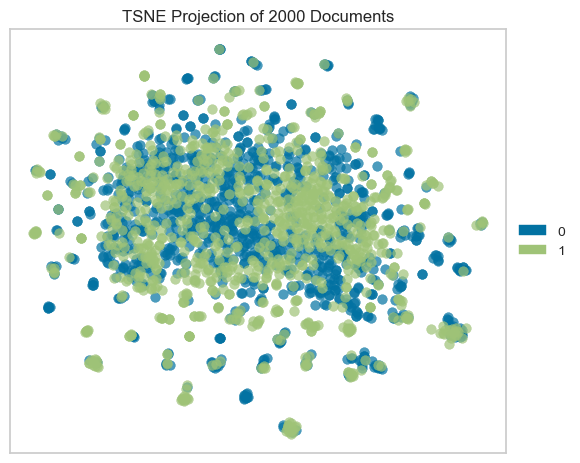

<AxesSubplot:title={'center':'TSNE Projection of 2000 Documents'}>

In [29]:
#Using t-SNE to visualize
tsne = TSNEVisualizer(labels=data.target_names)
tsne.fit(X,y)
tsne.show()

### Naive Bayes

In [30]:
params = {"tfidf__ngram_range": [(1, 1), (1, 2)],
          "naivebayes__alpha": [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}

clf = Pipeline([("tfidf", TfidfVectorizer(sublinear_tf=True)),
                ("naivebayes", MultinomialNB())])

In [31]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(data.data, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True)),
                ('naivebayes', MultinomialNB(alpha=1))])
0.8484999999999999


In [32]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(data.data, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True)),
                ('naivebayes', MultinomialNB(alpha=0.01))])
0.8375


In [33]:
#Save best score
result_df.loc["TF-IDF","Naive Bayes"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,NaN,0.8485,NaN,NaN,NaN
Word2Vec(CBoW),NaN,NaN,NaN,NaN,NaN
Word2Vec(Skip-Gram),NaN,NaN,NaN,NaN,NaN
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,NaN,NaN,NaN,NaN


### Logistic Regression

In [34]:
params = {"tfidf__ngram_range": [(1, 1), (1, 2)],
          "logreg__C": np.logspace(-3,3,7),
          "logreg__penalty":["l1","l2"]}

clf = Pipeline([("tfidf", TfidfVectorizer(sublinear_tf=True)),
                ("logreg", LogisticRegression())])

In [35]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(data.data, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Pipeline(steps=[('tfidf', TfidfVectorizer(sublinear_tf=True)),
                ('logreg', LogisticRegression(C=10.0))])
0.8795


In [36]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(data.data, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Pipeline(steps=[('tfidf', TfidfVectorizer(sublinear_tf=True)),
                ('logreg', LogisticRegression(C=10.0))])
0.8795


In [37]:
#Save best score
result_df.loc["TF-IDF","Logistic Regression"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,NaN,NaN,NaN
Word2Vec(CBoW),NaN,NaN,NaN,NaN,NaN
Word2Vec(Skip-Gram),NaN,NaN,NaN,NaN,NaN
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,NaN,NaN,NaN,NaN


### K-Nearest Neighbours

In [38]:
params = {"tfidf__ngram_range": [(1, 1), (1, 2)],
          "knn__n_neighbors":  [1,5,10,20]}

clf = Pipeline([("tfidf", TfidfVectorizer(sublinear_tf=True)),
                ("knn", KNeighborsClassifier())])

In [39]:
# gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
# gs.fit(data.data, data.target)
# print(gs.best_estimator_)
# print(gs.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True)),
                ('knn', KNeighborsClassifier(n_neighbors=20))])
0.7709999999999999


In [40]:
# rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
# rs.fit(data.data, data.target)
# print(rs.best_estimator_)
# print(rs.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True)),
                ('knn', KNeighborsClassifier(n_neighbors=20))])
0.7709999999999999


In [41]:
# #Save best score
# result_df.loc["TF-IDF","K-Nearest Neighbours"] = max(rs.best_score_,gs.best_score_)
# result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,NaN,NaN
Word2Vec(CBoW),NaN,NaN,NaN,NaN,NaN
Word2Vec(Skip-Gram),NaN,NaN,NaN,NaN,NaN
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,NaN,NaN,NaN,NaN


### SVM

In [42]:
params = {"tfidf__ngram_range": [(1, 1), (1, 2)],
          "svc__C": [.01, .1, 1, 10, 100]}

clf = Pipeline([("tfidf", TfidfVectorizer(sublinear_tf=True)),
                ("svc", LinearSVC())])

In [43]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(data.data, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Pipeline(steps=[('tfidf', TfidfVectorizer(sublinear_tf=True)),
                ('svc', LinearSVC(C=1))])
0.8770000000000001


In [44]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(data.data, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Pipeline(steps=[('tfidf', TfidfVectorizer(sublinear_tf=True)),
                ('svc', LinearSVC(C=1))])
0.8770000000000001


In [45]:
#Save best score
result_df.loc["TF-IDF","Support Vector Machine"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,NaN
Word2Vec(CBoW),NaN,NaN,NaN,NaN,NaN
Word2Vec(Skip-Gram),NaN,NaN,NaN,NaN,NaN
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,NaN,NaN,NaN,NaN


### Random Forest

In [46]:
params = {"tfidf__ngram_range": [(1, 1), (1, 2)],
          "rf__n_estimators": [10,100,1000]}

clf = Pipeline([("tfidf", TfidfVectorizer(sublinear_tf=True)),
                ("rf", RandomForestClassifier())])

In [47]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(data.data, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Pipeline(steps=[('tfidf', TfidfVectorizer(sublinear_tf=True)),
                ('rf', RandomForestClassifier(n_estimators=1000))])
0.8240000000000001


In [48]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(data.data, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Pipeline(steps=[('tfidf', TfidfVectorizer(sublinear_tf=True)),
                ('rf', RandomForestClassifier(n_estimators=1000))])
0.8184999999999999


In [49]:
#Save best score
result_df.loc["TF-IDF","Random Forest"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,0.824
Word2Vec(CBoW),NaN,NaN,NaN,NaN,NaN
Word2Vec(Skip-Gram),NaN,NaN,NaN,NaN,NaN
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,NaN,NaN,NaN,NaN


[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.1; total time=   1.5s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=1e-05; total time=   1.4s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=0.01; total time=   1.4s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=1e-05; total time=   1.5s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=0.01; total time=   1.8s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=1; total time=   1.3s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=1e-05; total time=   1.6s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=0.1; total time=   1.7s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=1e-05; total time=   1.0s
[CV] END count_vectorizer__max_features=5, logreg__C=0.001, logreg__penalty=l1; total time=   1.1s
[CV] END count_vectorizer__max_features=5, logreg__C=0.1, logreg__penalty=l1; total time=   1.1s
[CV] END count_vectorizer

/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3

[CV] END count_vectorizer__max_features=5, naivebayes__alpha=1; total time=   1.5s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.001; total time=   1.4s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=1; total time=   1.4s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=0.001; total time=   1.5s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=1; total time=   1.7s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=0.0001; total time=   1.4s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=0.01; total time=   1.5s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=1e-05; total time=   1.6s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.1; total time=   1.6s
[CV] END count_vectorizer__max_features=5, logreg__C=0.001, logreg__penalty=l1; total time=   1.1s
[CV] END count_vectorizer__max_features=5, logreg__C=0.01, logreg__penalty=l2; total time=   3.9s
[CV] END count_vectorizer__m

/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3

[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.1; total time=   1.4s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.0001; total time=   1.4s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=0.01; total time=   1.4s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=1e-05; total time=   1.5s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=0.01; total time=   1.8s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=1e-05; total time=   1.2s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.001; total time=   1.4s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=1; total time=   1.6s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.0001; total time=   1.7s
[CV] END count_vectorizer__max_features=5, logreg__C=0.01, logreg__penalty=l1; total time=   1.2s
[CV] END count_vectorizer__max_features=5, logreg__C=0.1, logreg__penalty=l1; total time=   1.1s
[CV] END count_vectoriz

/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3

[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.01; total time=   1.5s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=1e-05; total time=   1.4s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=0.01; total time=   1.4s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=1e-05; total time=   1.5s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=0.001; total time=   1.8s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.001; total time=   1.5s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=1; total time=   1.6s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.0001; total time=   1.6s
[CV] END count_vectorizer__max_features=5, logreg__C=0.001, logreg__penalty=l2; total time=   3.8s
[CV] END count_vectorizer__max_features=5, logreg__C=1.0, logreg__penalty=l1; total time=   1.2s
[CV] END count_vectorizer__max_features=5, logreg__C=10.0, logreg__penalty=l1; total time=   1.4s
[CV] END co

/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3

[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.01; total time=   1.5s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=1e-05; total time=   1.4s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=0.01; total time=   1.4s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=1; total time=   1.5s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=0.001; total time=   1.8s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=0.01; total time=   1.5s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=1e-05; total time=   1.6s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.1; total time=   1.6s
[CV] END count_vectorizer__max_features=5, logreg__C=0.001, logreg__penalty=l1; total time=   1.0s
[CV] END count_vectorizer__max_features=5, logreg__C=0.01, logreg__penalty=l2; total time=   3.8s
[CV] END count_vectorizer__max_features=5, logreg__C=1.0, logreg__penalty=l2; total time=   1.6s
[CV] END count

/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3

[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.01; total time=   1.5s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=1e-05; total time=   1.4s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=0.001; total time=   1.4s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=1; total time=   1.6s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=0.001; total time=   1.8s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.001; total time=   1.5s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=1e-05; total time=   1.6s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.1; total time=   1.6s
[CV] END count_vectorizer__max_features=5, logreg__C=0.001, logreg__penalty=l2; total time=   3.8s
[CV] END count_vectorizer__max_features=5, logreg__C=1.0, logreg__penalty=l1; total time=   1.2s
[CV] END count_vectorizer__max_features=5, logreg__C=10.0, logreg__penalty=l2; total time=   1.6s
[CV] END coun

/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3

[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.1; total time=   1.5s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.0001; total time=   1.4s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=0.1; total time=   1.4s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=0.0001; total time=   1.5s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=0.1; total time=   1.8s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=1e-05; total time=   1.3s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.001; total time=   1.5s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=1; total time=   1.6s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.0001; total time=   1.6s
[CV] END count_vectorizer__max_features=5, logreg__C=0.01, logreg__penalty=l1; total time=   1.3s
[CV] END count_vectorizer__max_features=5, logreg__C=0.1, logreg__penalty=l2; total time=   3.8s
[CV] END count_vectorize

/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3

[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.001; total time=   1.4s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=1; total time=   1.4s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=0.001; total time=   1.5s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=1; total time=   1.6s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=0.001; total time=   1.8s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=1; total time=   1.4s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=1; total time=   1.6s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.0001; total time=   1.6s
[CV] END count_vectorizer__max_features=5, logreg__C=0.01, logreg__penalty=l1; total time=   1.3s
[CV] END count_vectorizer__max_features=5, logreg__C=0.1, logreg__penalty=l1; total time=   1.1s
[CV] END count_vectorizer__max_features=5, logreg__C=0.1, logreg__penalty=l2; total time=   4.0s
[CV] END count_vector

/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3

[CV] END count_vectorizer__max_features=5, naivebayes__alpha=1; total time=   1.5s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.001; total time=   1.4s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=0.1; total time=   1.5s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=0.0001; total time=   1.5s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=0.1; total time=   1.8s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=0.0001; total time=   1.3s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=0.01; total time=   1.5s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=0.1; total time=   1.6s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=1e-05; total time=   1.5s
[CV] END count_vectorizer__max_features=5, logreg__C=0.001, logreg__penalty=l2; total time=   3.8s
[CV] END count_vectorizer__max_features=5, logreg__C=1.0, logreg__penalty=l1; total time=   1.2s
[CV] END count_vectorize

/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3

[CV] END count_vectorizer__max_features=5, naivebayes__alpha=1; total time=   1.5s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.001; total time=   1.4s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=1; total time=   1.4s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=0.001; total time=   1.4s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=0.1; total time=   1.7s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=0.0001; total time=   1.3s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=1e-05; total time=   1.5s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=0.1; total time=   1.6s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=1e-05; total time=   1.5s
[CV] END count_vectorizer__max_features=5, logreg__C=0.001, logreg__penalty=l2; total time=   3.9s
[CV] END count_vectorizer__max_features=5, logreg__C=1.0, logreg__penalty=l2; total time=   1.5s
[CV] END count_vectorizer_

/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3

[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.01; total time=   1.5s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=1; total time=   1.4s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=0.001; total time=   1.5s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=1; total time=   1.6s
[CV] END count_vectorizer__max_features=20, naivebayes__alpha=0.001; total time=   1.8s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=1; total time=   1.4s
[CV] END count_vectorizer__max_features=10, naivebayes__alpha=1e-05; total time=   1.6s
[CV] END count_vectorizer__max_features=5, naivebayes__alpha=0.0001; total time=   1.7s
[CV] END count_vectorizer__max_features=5, logreg__C=0.01, logreg__penalty=l2; total time=   3.9s
[CV] END count_vectorizer__max_features=5, logreg__C=1.0, logreg__penalty=l2; total time=   1.5s
[CV] END count_vectorizer__max_features=5, logreg__C=10.0, logreg__penalty=l2; total time=   1.6s
[CV] END count_ve

/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anantagarwal/opt/anaconda3/lib/python3

## Word2Vec (Skip-Gram)

In [50]:
OUTPUT_FOLDER = "example_data/"

### Text Preprocessing

The first thing to do for any data science task is to clean the data. For NLP, we apply various processing like converting all the words to lower case, trimming spaces, removing punctuations. This is something we will do over here too.

Additionally, we will also remove stop words like 'and', 'or', 'is', 'the', 'a', 'an' and convert words to their root forms like 'running' to 'run'.

In [51]:
#Removing stop words
review_data = pd.Series(data.data).apply(remove_stopwords)
review_data.loc[0]

"arnold schwarzenegger icon action enthusiasts , late 80's , lately films sloppy one-liners getting worse . it's hard seeing arnold mr . freeze batman robin , especially says tons ice jokes , hey got 15 million , what's matter ? arnold signed expensive blockbuster , can't compare likes terminator series , true lies eraser . called dark thriller , devil ( gabriel byrne ) come earth , impregnate woman ( robin tunney ) happens 1000 years , basically destroy world , apparently god chosen man , man jericho cane ( arnold ) . help trusty sidekick ( kevin pollack ) , stop let devil world ! parts actually absurd , fit right dogma . yes , film weak , it's better blockbuster right ( sleepy hollow ) , makes world look like 4 star film . , definitely doesn't like arnold movie . wasn't type film . sure gave chuckles known one-liners , confused character film going . it's understandable , especially ending changed according sources . aside form , walked , like past films . i'm sorry arnold maybe end 

In [52]:
#Tokenize
review_data_tkn = review_data.apply(simple_preprocess)
review_data_tkn.loc[0]

['arnold',
 'schwarzenegger',
 'icon',
 'action',
 'enthusiasts',
 'late',
 'lately',
 'films',
 'sloppy',
 'one',
 'liners',
 'getting',
 'worse',
 'it',
 'hard',
 'seeing',
 'arnold',
 'mr',
 'freeze',
 'batman',
 'robin',
 'especially',
 'says',
 'tons',
 'ice',
 'jokes',
 'hey',
 'got',
 'million',
 'what',
 'matter',
 'arnold',
 'signed',
 'expensive',
 'blockbuster',
 'can',
 'compare',
 'likes',
 'terminator',
 'series',
 'true',
 'lies',
 'eraser',
 'called',
 'dark',
 'thriller',
 'devil',
 'gabriel',
 'byrne',
 'come',
 'earth',
 'impregnate',
 'woman',
 'robin',
 'tunney',
 'happens',
 'years',
 'basically',
 'destroy',
 'world',
 'apparently',
 'god',
 'chosen',
 'man',
 'man',
 'jericho',
 'cane',
 'arnold',
 'help',
 'trusty',
 'sidekick',
 'kevin',
 'pollack',
 'stop',
 'let',
 'devil',
 'world',
 'parts',
 'actually',
 'absurd',
 'fit',
 'right',
 'dogma',
 'yes',
 'film',
 'weak',
 'it',
 'better',
 'blockbuster',
 'right',
 'sleepy',
 'hollow',
 'makes',
 'world',
 'l

In [53]:
#Stemming
porter_stemmer = PorterStemmer()

In [54]:
# Get the stemmed tokens
review_data_stemmed = pd.Series([[porter_stemmer.stem(word) for word in tokens] for tokens in review_data_tkn])
review_data_stemmed.head(10)

0    [arnold, schwarzenegg, icon, action, enthusias...
1    [good, film, hard, dai, great, film, rare, pro...
2    [quaid, star, man, taken, proffes, dragonslay,...
3    [paraphras, michel, pfieffer, charact, danger,...
4    [kolya, richest, film, ve, seen, time, zdenek,...
5    [don, know, peopl, idea, cross, mind, life, on...
6    [capsul, trippi, hyperspe, action, machin, hon...
7    [gothic, murder, mysteri, yarn, new, conceit, ...
8    [look, movi, necessarili, perfect, movi, stron...
9    [law, crowd, pleas, romant, movi, state, lead,...
dtype: object

### Getting Word Vectors

In [55]:
###Initialize Word2Vec model
# Skip-gram model (sg = 1)
window = 3
min_count = 1
workers = 3
sg = 1
model = Word2Vec(review_data_stemmed, 
                 min_count = min_count, 
                 workers = workers, 
                 window = window, 
                 sg = sg)

In [56]:
# Unique ID of the word
print("Index of the word 'action':")
print(model.wv.key_to_index["action"])

# Total number of the words 
print(len(model.wv))

# Print the size of the word2vec vector for one word
print("Length of the vector generated for a word")
print(len(model.wv['action']))

# Get the mean for the vectors for an example review
print("Print the length after taking average of all word vectors in a sentence:")
print(len(np.mean([model.wv[token] for token in review_data_stemmed[0]], axis=0)))

Index of the word 'action':
33
25404
Length of the vector generated for a word
100
Print the length after taking average of all word vectors in a sentence:
100


In [57]:
# Get the vectors for stemmed data
features_word2vec = []
for index, row in review_data_stemmed.items():
    model_vector = (np.mean([model.wv[token] for token in row], axis=0)).tolist()
    # Check if the line exists else it is vector of zeros
    if type(model_vector) is list:  
        features_word2vec.append(model_vector)
    else:
        features_word2vec.append(np.array([0 for i in range(model.vector_size)]))

In [58]:
#Shape of the input matrix
np.array(features_word2vec).shape

(2000, 100)

In [59]:
#Scaling for Naive Bayes
scaler = MinMaxScaler()
features_word2vec_scaled = scaler.fit_transform(features_word2vec)

### Naive Bayes

In [60]:
params = {"naivebayes__alpha": [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}

clf = Pipeline([("naivebayes", MultinomialNB())])

In [61]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(features_word2vec_scaled, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Pipeline(steps=[('naivebayes', MultinomialNB(alpha=1))])
0.6679999999999999


In [62]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(features_word2vec_scaled, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Pipeline(steps=[('naivebayes', MultinomialNB(alpha=1))])
0.6679999999999999


In [63]:
#Save best score
result_df.loc["Word2Vec(Skip-Gram)","Naive Bayes"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,0.824
Word2Vec(CBoW),NaN,NaN,NaN,NaN,NaN
Word2Vec(Skip-Gram),NaN,0.668,NaN,NaN,NaN
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,NaN,NaN,NaN,NaN


### Logistic Regression

In [64]:
params = {"logreg__C": np.logspace(-3,3,7),
          "logreg__penalty":["l1","l2"]}

clf = Pipeline([("logreg", LogisticRegression())])

In [65]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(features_word2vec, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Pipeline(steps=[('logreg', LogisticRegression(C=1000.0))])
0.758


In [66]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(features_word2vec, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Pipeline(steps=[('logreg', LogisticRegression(C=1000.0))])
0.758


In [67]:
#Save best score
result_df.loc["Word2Vec(Skip-Gram)","Logistic Regression"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,0.824
Word2Vec(CBoW),NaN,NaN,NaN,NaN,NaN
Word2Vec(Skip-Gram),0.758,0.668,NaN,NaN,NaN
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,NaN,NaN,NaN,NaN


### K-Nearest Neighbours

In [68]:
params = {"knn__n_neighbors": [1,5,10,20]}

clf = Pipeline([("knn", KNeighborsClassifier())])

In [69]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(features_word2vec, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Pipeline(steps=[('knn', KNeighborsClassifier(n_neighbors=20))])
0.6925


In [70]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(features_word2vec, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Pipeline(steps=[('knn', KNeighborsClassifier(n_neighbors=20))])
0.6925


In [71]:
#Save best score
result_df.loc["Word2Vec(Skip-Gram)","K-Nearest Neighbours"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,0.824
Word2Vec(CBoW),NaN,NaN,NaN,NaN,NaN
Word2Vec(Skip-Gram),0.758,0.668,0.6925,NaN,NaN
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,NaN,NaN,NaN,NaN


### SVM

In [72]:
params = {"svc__C": [.01, .1, 1, 10, 100]}

clf = Pipeline([("svc", LinearSVC())])

In [73]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(features_word2vec, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Pipeline(steps=[('svc', LinearSVC(C=100))])
0.7585


In [74]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(features_word2vec, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Pipeline(steps=[('svc', LinearSVC(C=10))])
0.754


In [75]:
#Save best score
result_df.loc["Word2Vec(Skip-Gram)","Support Vector Machine"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,0.824
Word2Vec(CBoW),NaN,NaN,NaN,NaN,NaN
Word2Vec(Skip-Gram),0.758,0.668,0.6925,0.7585,NaN
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,NaN,NaN,NaN,NaN


### Random Forest

In [76]:
params = {"rf__n_estimators": [10,100,1000]}

clf = Pipeline([("rf", RandomForestClassifier())])

In [77]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(features_word2vec, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Pipeline(steps=[('rf', RandomForestClassifier())])
0.7225


In [78]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(features_word2vec, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Pipeline(steps=[('rf', RandomForestClassifier(n_estimators=1000))])
0.7185


In [79]:
#Save best score
result_df.loc["Word2Vec(Skip-Gram)","Random Forest"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,0.824
Word2Vec(CBoW),NaN,NaN,NaN,NaN,NaN
Word2Vec(Skip-Gram),0.758,0.668,0.6925,0.7585,0.7225
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,NaN,NaN,NaN,NaN


## Word2Vec (CBoW)

In [80]:
OUTPUT_FOLDER = "example_data/"

### Text Preprocessing

The first thing to do for any data science task is to clean the data. For NLP, we apply various processing like converting all the words to lower case, trimming spaces, removing punctuations. This is something we will do over here too.

Additionally, we will also remove stop words like 'and', 'or', 'is', 'the', 'a', 'an' and convert words to their root forms like 'running' to 'run'.

In [81]:
#Removing stop words
review_data = pd.Series(data.data).apply(remove_stopwords)
review_data.loc[0]

"arnold schwarzenegger icon action enthusiasts , late 80's , lately films sloppy one-liners getting worse . it's hard seeing arnold mr . freeze batman robin , especially says tons ice jokes , hey got 15 million , what's matter ? arnold signed expensive blockbuster , can't compare likes terminator series , true lies eraser . called dark thriller , devil ( gabriel byrne ) come earth , impregnate woman ( robin tunney ) happens 1000 years , basically destroy world , apparently god chosen man , man jericho cane ( arnold ) . help trusty sidekick ( kevin pollack ) , stop let devil world ! parts actually absurd , fit right dogma . yes , film weak , it's better blockbuster right ( sleepy hollow ) , makes world look like 4 star film . , definitely doesn't like arnold movie . wasn't type film . sure gave chuckles known one-liners , confused character film going . it's understandable , especially ending changed according sources . aside form , walked , like past films . i'm sorry arnold maybe end 

In [82]:
#Tokenize
review_data_tkn = review_data.apply(simple_preprocess)
review_data_tkn.loc[0]

['arnold',
 'schwarzenegger',
 'icon',
 'action',
 'enthusiasts',
 'late',
 'lately',
 'films',
 'sloppy',
 'one',
 'liners',
 'getting',
 'worse',
 'it',
 'hard',
 'seeing',
 'arnold',
 'mr',
 'freeze',
 'batman',
 'robin',
 'especially',
 'says',
 'tons',
 'ice',
 'jokes',
 'hey',
 'got',
 'million',
 'what',
 'matter',
 'arnold',
 'signed',
 'expensive',
 'blockbuster',
 'can',
 'compare',
 'likes',
 'terminator',
 'series',
 'true',
 'lies',
 'eraser',
 'called',
 'dark',
 'thriller',
 'devil',
 'gabriel',
 'byrne',
 'come',
 'earth',
 'impregnate',
 'woman',
 'robin',
 'tunney',
 'happens',
 'years',
 'basically',
 'destroy',
 'world',
 'apparently',
 'god',
 'chosen',
 'man',
 'man',
 'jericho',
 'cane',
 'arnold',
 'help',
 'trusty',
 'sidekick',
 'kevin',
 'pollack',
 'stop',
 'let',
 'devil',
 'world',
 'parts',
 'actually',
 'absurd',
 'fit',
 'right',
 'dogma',
 'yes',
 'film',
 'weak',
 'it',
 'better',
 'blockbuster',
 'right',
 'sleepy',
 'hollow',
 'makes',
 'world',
 'l

In [83]:
#Stemming
porter_stemmer = PorterStemmer()

In [84]:
# Get the stemmed tokens
review_data_stemmed = pd.Series([[porter_stemmer.stem(word) for word in tokens] for tokens in review_data_tkn])
review_data_stemmed.head(10)

0    [arnold, schwarzenegg, icon, action, enthusias...
1    [good, film, hard, dai, great, film, rare, pro...
2    [quaid, star, man, taken, proffes, dragonslay,...
3    [paraphras, michel, pfieffer, charact, danger,...
4    [kolya, richest, film, ve, seen, time, zdenek,...
5    [don, know, peopl, idea, cross, mind, life, on...
6    [capsul, trippi, hyperspe, action, machin, hon...
7    [gothic, murder, mysteri, yarn, new, conceit, ...
8    [look, movi, necessarili, perfect, movi, stron...
9    [law, crowd, pleas, romant, movi, state, lead,...
dtype: object

### Getting Word Vectors

In [85]:
###Initialize Word2Vec model
# CBoW model (sg = 1)
window = 3
min_count = 1
workers = 3
sg = 0
model = Word2Vec(review_data_stemmed, 
                 min_count = min_count, 
                 workers = workers, 
                 window = window, 
                 sg = sg)

In [86]:
# Unique ID of the word
print("Index of the word 'action':")
print(model.wv.key_to_index["action"])

# Total number of the words 
print(len(model.wv))

# Print the size of the word2vec vector for one word
print("Length of the vector generated for a word")
print(len(model.wv['action']))

# Get the mean for the vectors for an example review
print("Print the length after taking average of all word vectors in a sentence:")
print(len(np.mean([model.wv[token] for token in review_data_stemmed[0]], axis=0)))

Index of the word 'action':
33
25404
Length of the vector generated for a word
100
Print the length after taking average of all word vectors in a sentence:
100


In [87]:
# Get the vectors for stemmed data
features_word2vec = []
for index, row in review_data_stemmed.items():
    model_vector = (np.mean([model.wv[token] for token in row], axis=0)).tolist()
    # Check if the line exists else it is vector of zeros
    if type(model_vector) is list:  
        features_word2vec.append(model_vector)
    else:
        features_word2vec.append(np.array([0 for i in range(model.vector_size)]))

In [88]:
#Shape of the input matrix
np.array(features_word2vec).shape

(2000, 100)

In [89]:
#Scaling for Naive Bayes
scaler = MinMaxScaler()
features_word2vec_scaled = scaler.fit_transform(features_word2vec)

### Naive Bayes

In [90]:
params = {"naivebayes__alpha": [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}

clf = Pipeline([("naivebayes", MultinomialNB())])

In [91]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(features_word2vec_scaled, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Pipeline(steps=[('naivebayes', MultinomialNB(alpha=1))])
0.5835


In [92]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(features_word2vec_scaled, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Pipeline(steps=[('naivebayes', MultinomialNB(alpha=1))])
0.5835


In [93]:
#Save best score
result_df.loc["Word2Vec(CBoW)","Naive Bayes"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,0.824
Word2Vec(CBoW),NaN,0.5835,NaN,NaN,NaN
Word2Vec(Skip-Gram),0.758,0.668,0.6925,0.7585,0.7225
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,NaN,NaN,NaN,NaN


### Logistic Regression

In [94]:
params = {"logreg__C": np.logspace(-3,3,7),
          "logreg__penalty":["l1","l2"]}

clf = Pipeline([("logreg", LogisticRegression())])

In [95]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(features_word2vec, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Pipeline(steps=[('logreg', LogisticRegression(C=1000.0))])
0.7125


In [96]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(features_word2vec, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Pipeline(steps=[('logreg', LogisticRegression(C=1000.0))])
0.7125


In [97]:
#Save best score
result_df.loc["Word2Vec(CBoW)","Logistic Regression"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,0.824
Word2Vec(CBoW),0.7125,0.5835,NaN,NaN,NaN
Word2Vec(Skip-Gram),0.758,0.668,0.6925,0.7585,0.7225
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,NaN,NaN,NaN,NaN


### K-Nearest Neighbours

In [98]:
params = {"knn__n_neighbors": [1,5,10,20]}

clf = Pipeline([("knn", KNeighborsClassifier())])

In [99]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(features_word2vec, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Pipeline(steps=[('knn', KNeighborsClassifier(n_neighbors=20))])
0.6220000000000001


In [100]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(features_word2vec, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Pipeline(steps=[('knn', KNeighborsClassifier(n_neighbors=20))])
0.6220000000000001


In [101]:
#Save best score
result_df.loc["Word2Vec(CBoW)","K-Nearest Neighbours"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,0.824
Word2Vec(CBoW),0.7125,0.5835,0.622,NaN,NaN
Word2Vec(Skip-Gram),0.758,0.668,0.6925,0.7585,0.7225
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,NaN,NaN,NaN,NaN


### SVM

In [102]:
params = {"svc__C": [.01, .1, 1, 10, 100]}

clf = Pipeline([("svc", LinearSVC())])

In [103]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(features_word2vec, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Pipeline(steps=[('svc', LinearSVC(C=10))])
0.719


In [104]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(features_word2vec, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Pipeline(steps=[('svc', LinearSVC(C=10))])
0.7204999999999999


In [105]:
#Save best score
result_df.loc["Word2Vec(CBoW)","Support Vector Machine"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,0.824
Word2Vec(CBoW),0.7125,0.5835,0.622,0.7205,NaN
Word2Vec(Skip-Gram),0.758,0.668,0.6925,0.7585,0.7225
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,NaN,NaN,NaN,NaN


### Random Forest

In [106]:
params = {"rf__n_estimators": [10,100,1000]}

clf = Pipeline([("rf", RandomForestClassifier())])

In [107]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(features_word2vec, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Pipeline(steps=[('rf', RandomForestClassifier(n_estimators=1000))])
0.6595000000000001


In [108]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(features_word2vec, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Pipeline(steps=[('rf', RandomForestClassifier(n_estimators=1000))])
0.6575


In [109]:
#Save best score
result_df.loc["Word2Vec(CBoW)","Random Forest"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,0.824
Word2Vec(CBoW),0.7125,0.5835,0.622,0.7205,0.6595
Word2Vec(Skip-Gram),0.758,0.668,0.6925,0.7585,0.7225
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,NaN,NaN,NaN,NaN


## Universal Sentence Encoder

### Getting Sentence Embeddings

In [110]:
#Load USE model from TensorFlow Hub
url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param 
model = hub.load(url)

2023-07-08 15:27:58.503993: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [111]:
#Reduce logging output
logging.set_verbosity(logging.ERROR)

In [112]:
#Get sentence embeddings from data
use_emb = model(data.data)

In [113]:
#See embedding
np.array(use_emb).tolist()[0]

[-0.04078944772481918,
 -0.06032659858465195,
 -0.04345656931400299,
 0.04009928181767464,
 -0.0004886150709353387,
 0.06377539038658142,
 0.022045830264687538,
 -0.019395021721720695,
 0.06347382068634033,
 -0.01729961298406124,
 0.06338900327682495,
 0.008428175933659077,
 -0.0036823360715061426,
 0.034620363265275955,
 0.059929974377155304,
 -0.06117146089673042,
 0.011879665777087212,
 -0.009199387393891811,
 0.05312620475888252,
 0.05551179498434067,
 -0.0055627296678721905,
 -0.06705371290445328,
 -0.02495522052049637,
 0.062076155096292496,
 0.0543057844042778,
 -0.029435142874717712,
 -0.014372673816978931,
 0.03232262656092644,
 8.11274949228391e-05,
 0.0670538991689682,
 -0.03312945365905762,
 -0.007327796425670385,
 -0.02901964820921421,
 -0.0416567400097847,
 -0.02307375892996788,
 0.05107690766453743,
 0.001502998755313456,
 0.029043706133961678,
 -0.05418074503540993,
 -0.004452354274690151,
 0.04249237850308418,
 -0.052256010472774506,
 -0.06704534590244293,
 -0.02337917

In [114]:
#Check embedding size
len(np.array(use_emb).tolist()[0])

512

In [115]:
#Scaling for Naive Bayes
scaler = MinMaxScaler()
use_emb_scaled = scaler.fit_transform(use_emb.numpy())

### Naive Bayes

In [116]:
params = {"naivebayes__alpha": [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}

clf = Pipeline([("naivebayes", MultinomialNB())])

In [117]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(use_emb_scaled, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Pipeline(steps=[('naivebayes', MultinomialNB(alpha=1))])
0.7535000000000001


In [118]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(use_emb_scaled, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Pipeline(steps=[('naivebayes', MultinomialNB(alpha=1))])
0.7535000000000001


In [119]:
#Save best score
result_df.loc["USE","Naive Bayes"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,0.824
Word2Vec(CBoW),0.7125,0.5835,0.622,0.7205,0.6595
Word2Vec(Skip-Gram),0.758,0.668,0.6925,0.7585,0.7225
ELMo,NaN,NaN,NaN,NaN,NaN
USE,NaN,0.7535,NaN,NaN,NaN


### Logistic Regression

In [120]:
params = {"logreg__C": np.logspace(-3,3,7),
          "logreg__penalty":["l1","l2"]}

clf = Pipeline([("logreg", LogisticRegression())])

In [121]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(use_emb.numpy(), data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Pipeline(steps=[('logreg', LogisticRegression(C=10.0))])
0.8355


In [122]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(use_emb.numpy(), data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Pipeline(steps=[('logreg', LogisticRegression(C=10.0))])
0.8355


In [123]:
#Save best score
result_df.loc["USE","Logistic Regression"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,0.824
Word2Vec(CBoW),0.7125,0.5835,0.622,0.7205,0.6595
Word2Vec(Skip-Gram),0.758,0.668,0.6925,0.7585,0.7225
ELMo,NaN,NaN,NaN,NaN,NaN
USE,0.8355,0.7535,NaN,NaN,NaN


### K-Nearest Neighbours

In [124]:
params = {"knn__n_neighbors": [1,5,10,20]}

clf = Pipeline([("knn", KNeighborsClassifier())])

In [125]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(use_emb.numpy(), data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Pipeline(steps=[('knn', KNeighborsClassifier())])
0.727


In [126]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(use_emb.numpy(), data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Pipeline(steps=[('knn', KNeighborsClassifier())])
0.727


In [127]:
#Save best score
result_df.loc["USE","K-Nearest Neighbours"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,0.824
Word2Vec(CBoW),0.7125,0.5835,0.622,0.7205,0.6595
Word2Vec(Skip-Gram),0.758,0.668,0.6925,0.7585,0.7225
ELMo,NaN,NaN,NaN,NaN,NaN
USE,0.8355,0.7535,0.727,NaN,NaN


### SVM

In [128]:
params = {"svc__C": [.01, .1, 1, 10, 100]}

clf = Pipeline([("svc", LinearSVC())])

In [129]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(use_emb.numpy(), data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Pipeline(steps=[('svc', LinearSVC(C=1))])
0.8355


In [130]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(use_emb.numpy(), data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Pipeline(steps=[('svc', LinearSVC(C=1))])
0.8355


In [131]:
#Save best score
result_df.loc["USE","Support Vector Machine"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,0.824
Word2Vec(CBoW),0.7125,0.5835,0.622,0.7205,0.6595
Word2Vec(Skip-Gram),0.758,0.668,0.6925,0.7585,0.7225
ELMo,NaN,NaN,NaN,NaN,NaN
USE,0.8355,0.7535,0.727,0.8355,NaN


### Random Forest

In [132]:
params = {"rf__n_estimators": [10,100,1000]}

clf = Pipeline([("rf", RandomForestClassifier())])

In [133]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(use_emb.numpy(), data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Pipeline(steps=[('rf', RandomForestClassifier(n_estimators=1000))])
0.8025


In [134]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(use_emb.numpy(), data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Pipeline(steps=[('rf', RandomForestClassifier(n_estimators=1000))])
0.805


In [135]:
#Save best score
result_df.loc["USE","Random Forest"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,0.824
Word2Vec(CBoW),0.7125,0.5835,0.622,0.7205,0.6595
Word2Vec(Skip-Gram),0.758,0.668,0.6925,0.7585,0.7225
ELMo,NaN,NaN,NaN,NaN,NaN
USE,0.8355,0.7535,0.727,0.8355,0.805


## ELMo 

### Getting embeddings

In [136]:
#Load ELMo model from TensorFlow Hub
url = "https://tfhub.dev/google/elmo/2"
model = hub.load(url).signatures["default"]

In [137]:
#Reduce logging output
logging.set_verbosity(logging.ERROR)

In [139]:
#Get embeddings from data
elmo_emb = []
for review in review_data_stemmed:
    embeddings = model(tf.constant(review))["elmo"]
    elmo_emb.append(tf.reduce_mean(embeddings,0).numpy())

In [140]:
elmo_emb_all = np.concatenate(elmo_emb, axis = 0)

In [141]:
#Check embedding size
len(elmo_emb_all.tolist()[0])

1024

In [142]:
#Scaling for Naive Bayes
scaler = MinMaxScaler()
elmo_emb_all_scaled = scaler.fit_transform(elmo_emb_all)

### Naive Bayes

In [143]:
params = {"naivebayes__alpha": [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}

clf = Pipeline([("naivebayes", MultinomialNB())])

In [144]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(elmo_emb_all_scaled, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Pipeline(steps=[('naivebayes', MultinomialNB(alpha=1))])
0.672


In [145]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(elmo_emb_all_scaled, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Pipeline(steps=[('naivebayes', MultinomialNB(alpha=1))])
0.672


In [146]:
#Save best score
result_df.loc["ELMo","Naive Bayes"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,0.824
Word2Vec(CBoW),0.7125,0.5835,0.622,0.7205,0.6595
Word2Vec(Skip-Gram),0.758,0.668,0.6925,0.7585,0.7225
ELMo,NaN,0.672,NaN,NaN,NaN
USE,0.8355,0.7535,0.727,0.8355,0.805


### Logistic Regression

In [147]:
params = {"logreg__C": np.logspace(-3,3,7),
          "logreg__penalty":["l1","l2"]}

clf = Pipeline([("logreg", LogisticRegression())])

In [148]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(elmo_emb_all, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Pipeline(steps=[('logreg', LogisticRegression(C=10.0))])
0.7799999999999999


In [149]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(elmo_emb_all, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Pipeline(steps=[('logreg', LogisticRegression())])
0.768


In [150]:
#Save best score
result_df.loc["ELMo","Logistic Regression"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,0.824
Word2Vec(CBoW),0.7125,0.5835,0.622,0.7205,0.6595
Word2Vec(Skip-Gram),0.758,0.668,0.6925,0.7585,0.7225
ELMo,0.78,0.672,NaN,NaN,NaN
USE,0.8355,0.7535,0.727,0.8355,0.805


### K-Nearest Neighbours

In [151]:
params = {"knn__n_neighbors": [1,5,10,20]}

clf = Pipeline([("knn", KNeighborsClassifier())])

In [152]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(elmo_emb_all, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Pipeline(steps=[('knn', KNeighborsClassifier())])
0.6695


In [153]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(elmo_emb_all, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Pipeline(steps=[('knn', KNeighborsClassifier())])
0.6695


In [154]:
#Save best score
result_df.loc["ELMo","K-Nearest Neighbours"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,0.824
Word2Vec(CBoW),0.7125,0.5835,0.622,0.7205,0.6595
Word2Vec(Skip-Gram),0.758,0.668,0.6925,0.7585,0.7225
ELMo,0.78,0.672,0.6695,NaN,NaN
USE,0.8355,0.7535,0.727,0.8355,0.805


### SVM

In [155]:
params = {"svc__C": [.01, .1, 1, 10, 100]}

clf = Pipeline([("svc", LinearSVC())])

In [156]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(elmo_emb_all, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Pipeline(steps=[('svc', LinearSVC(C=1))])
0.7779999999999999


In [157]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(elmo_emb_all, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Pipeline(steps=[('svc', LinearSVC(C=1))])
0.7779999999999999


In [158]:
#Save best score
result_df.loc["ELMo","Support Vector Machine"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,0.824
Word2Vec(CBoW),0.7125,0.5835,0.622,0.7205,0.6595
Word2Vec(Skip-Gram),0.758,0.668,0.6925,0.7585,0.7225
ELMo,0.78,0.672,0.6695,0.778,NaN
USE,0.8355,0.7535,0.727,0.8355,0.805


### Random Forest

In [159]:
params = {"rf__n_estimators": [10,100,1000]}

clf = Pipeline([("rf", RandomForestClassifier())])

In [160]:
gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(elmo_emb_all, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Pipeline(steps=[('rf', RandomForestClassifier(n_estimators=1000))])
0.7170000000000001


In [161]:
rs = RandomizedSearchCV(clf, params, verbose=2, n_jobs=-1)
rs.fit(elmo_emb_all, data.target)
print(rs.best_estimator_)
print(rs.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Pipeline(steps=[('rf', RandomForestClassifier(n_estimators=1000))])
0.7155


In [162]:
#Save best score
result_df.loc["ELMo","Random Forest"] = max(rs.best_score_,gs.best_score_)
result_df

,Logistic Regression,Naive Bayes,K-Nearest Neighbours,Support Vector Machine,Random Forest
BoW,0.658,0.637,0.5725,0.6545,0.631
TF-IDF,0.8795,0.8485,0.771,0.877,0.824
Word2Vec(CBoW),0.7125,0.5835,0.622,0.7205,0.6595
Word2Vec(Skip-Gram),0.758,0.668,0.6925,0.7585,0.7225
ELMo,0.78,0.672,0.6695,0.778,0.717
USE,0.8355,0.7535,0.727,0.8355,0.805


## GloVe

In [163]:
# urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','downloads/glove.6B.zip')

In [164]:
# https://nlp.stanford.edu/data/glove.6B.zip

In [165]:
# !unzip "downloads/glove.6B.zip" -d "downloads/"

unzip:  cannot find or open downloads/glove.6B.zip, downloads/glove.6B.zip.zip or downloads/glove.6B.zip.ZIP.


In [167]:
#Create dictionary holding word and its vector
emmbed_dict = {}
with open('downloads/glove.6B.200d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:],'float32')
        emmbed_dict[word]=vector

In [168]:
#Find similar words using Euclidean distance
def find_similar_word(emmbedes):
  nearest = sorted(emmbed_dict.keys(), key=lambda word: spatial.distance.euclidean(emmbed_dict[word], emmbedes))
  return nearest

In [169]:
find_similar_word(emmbed_dict['river'])[0:10]

['river',
 'rivers',
 'tributary',
 'confluence',
 'creek',
 'along',
 'tributaries',
 'valley',
 'flows',
 'danube']

In [170]:
find_similar_word(emmbed_dict['king'] + emmbed_dict['queen'] + emmbed_dict['prince'])[0:10]

['king',
 'prince',
 'queen',
 'princess',
 'crown',
 'throne',
 'royal',
 'monarch',
 'kingdom',
 'duke']

### Visualization using t-SNE

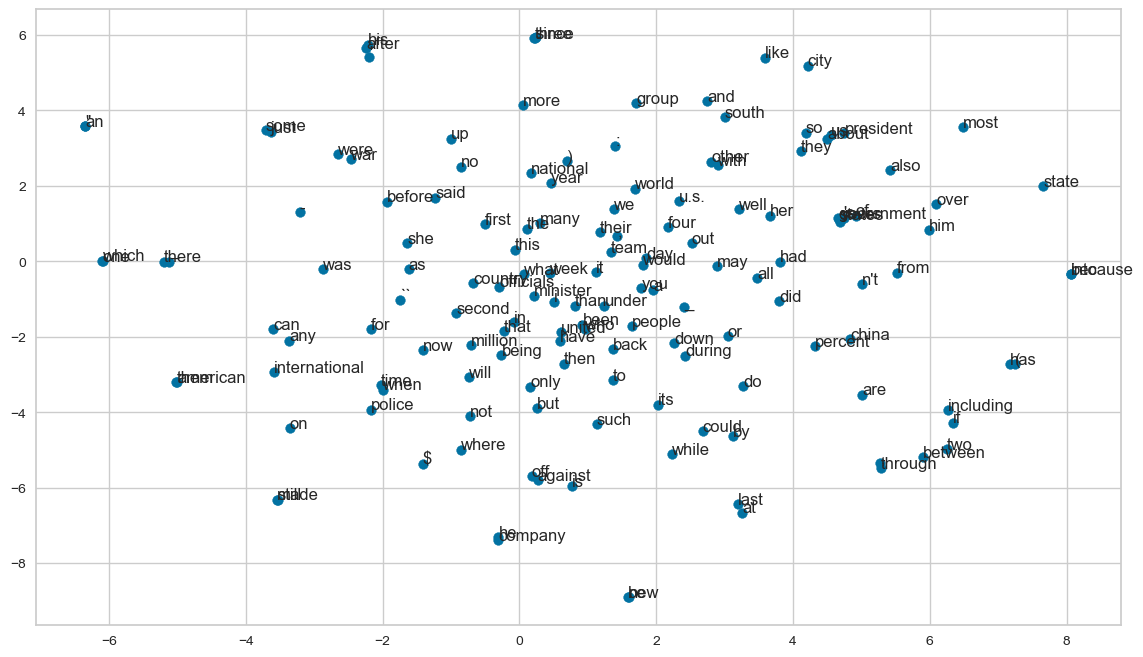

In [171]:
#Visualize using t-SNE
dist = TSNE(n_components=2)
words = list(emmbed_dict.keys())
vectors = [emmbed_dict[word] for word in words]
y = dist.fit_transform(vectors[700:850])
plt.figure(figsize=(14,8))
plt.scatter(y[:, 0],y[:,1])
for label,x,y in zip(words,y[:, 0],y[:,1]):
  plt.annotate(label,xy=(x,y),xytext=(0,0),textcoords='offset points')
plt.show()